Data Loading and Initial Setup

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats
warnings.filterwarnings('ignore')


plotting style

In [44]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Load datasets

In [45]:
print("Loading Fear & Greed Index data")
fgi_df = pd.read_csv('fear_greed_index.csv')
print(f"FGI data shape: {fgi_df.shape}")

print("\nLoading Historical Trader Data")
trader_df = pd.read_csv('historical_data.csv')
print(f"Trader data shape: {trader_df.shape}")

Loading Fear & Greed Index data
FGI data shape: (2644, 4)

Loading Historical Trader Data
Trader data shape: (211224, 16)


#Data Exploration & Cleaning



Explore FGI data

In [46]:
print("=== Fear & Greed Index Data ===")
print(fgi_df.head())
print(f"\nFGI date range: {fgi_df['date'].min()} to {fgi_df['date'].max()}")
print(f"\nSentiment distribution:")
print(fgi_df['classification'].value_counts())

=== Fear & Greed Index Data ===
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

FGI date range: 2018-02-01 to 2025-05-02

Sentiment distribution:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


Explore Trader data

In [47]:
print("=== Historical Trader Data ===")
print(trader_df.head())
print(f"\nColumns: {list(trader_df.columns)}")
print(f"\nData types:\n{trader_df.dtypes}")


=== Historical Trader Data ===
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Orde

Check for missing values

In [48]:
print("=== Missing Values ===")
print("FGI data:")
print(fgi_df.isnull().sum())
print("\nTrader data:")
print(trader_df.isnull().sum())


=== Missing Values ===
FGI data:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Trader data:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


Data cleaning for trader data

In [49]:
trader_df['timestamp'] = pd.to_datetime(trader_df['Timestamp IST'], format='mixed', dayfirst=True, errors='coerce')
trader_df['date'] = trader_df['timestamp'].dt.date

trader_df['Closed PnL'] = pd.to_numeric(trader_df['Closed PnL'], errors='coerce')
trader_df['Size USD'] = pd.to_numeric(trader_df['Size USD'], errors='coerce')
trader_df['Execution Price'] = pd.to_numeric(trader_df['Execution Price'], errors='coerce')

closed_trades = trader_df[trader_df['Closed PnL'].notna()]
print(f"Total trades: {len(trader_df)}")
print(f"Closed trades with PnL: {len(closed_trades)}")

Total trades: 211224
Closed trades with PnL: 211224


Clean FGI data

In [50]:
fgi_df['date'] = pd.to_datetime(fgi_df['date']).dt.date

Feature Engineering

In [51]:
print("Creating trader performance features")

trader_features = closed_trades.groupby('Account').agg({
    'Closed PnL': ['sum', 'mean', 'count'],
    'Size USD': 'mean',
    'Execution Price': 'mean'
}).round(2)

trader_features.columns = ['total_pnl', 'avg_pnl_per_trade', 'total_trades', 'avg_trade_size', 'avg_execution_price']
trader_features = trader_features.reset_index()

def calculate_win_rate(account):
    account_trades = closed_trades[closed_trades['Account'] == account]
    if len(account_trades) > 0:
        return len(account_trades[account_trades['Closed PnL'] > 0]) / len(account_trades)
    return 0

trader_features['win_rate'] = trader_features['Account'].apply(calculate_win_rate)

print(f"Features created for {len(trader_features)} unique traders")
print(f"Average win rate: {trader_features['win_rate'].mean():.2%}")

Creating trader performance features
Features created for 32 unique traders
Average win rate: 40.31%


Merge sentiment data with trader data

In [52]:
print("Merging sentiment data with trader performance...")

merged_data = closed_trades.merge(fgi_df, on='date', how='left')
print(f"Merged data shape: {merged_data.shape}")

print(f"Trades with sentiment data: {merged_data['classification'].notna().sum()}")
print(f"Trades without sentiment data: {merged_data['classification'].isna().sum()}")


Merging sentiment data with trader performance...
Merged data shape: (211224, 21)
Trades with sentiment data: 211218
Trades without sentiment data: 6


Data Quality Assessment & Outlier Handling

In [53]:
print("=== Data Quality Assessment ===")

print("PnL Statistics (Original):")
print(merged_data['Closed PnL'].describe())

print(f"\nData Quality Check:")
print(f"Total trades: {len(merged_data)}")
print(f"Trades with PnL > 0: {len(merged_data[merged_data['Closed PnL'] > 0])}")
print(f"Trades with PnL < 0: {len(merged_data[merged_data['Closed PnL'] < 0])}")
print(f"Trades with PnL = 0: {len(merged_data[merged_data['Closed PnL'] == 0])}")

pnl_lower = merged_data['Closed PnL'].quantile(0.01)
pnl_upper = merged_data['Closed PnL'].quantile(0.99)
filtered_data = merged_data[(merged_data['Closed PnL'] >= pnl_lower) & (merged_data['Closed PnL'] <= pnl_upper)]

print(f"\nAfter outlier removal (1%-99%):")
print(f"Remaining trades: {len(filtered_data)}")
print(f"Outliers removed: {len(merged_data) - len(filtered_data)}")
print(f"PnL Statistics (Filtered):")
print(filtered_data['Closed PnL'].describe())

=== Data Quality Assessment ===
PnL Statistics (Original):
count    211224.000000
mean         48.749001
std         919.164828
min     -117990.104100
25%           0.000000
50%           0.000000
75%           5.792797
max      135329.090100
Name: Closed PnL, dtype: float64

Data Quality Check:
Total trades: 211224
Trades with PnL > 0: 86869
Trades with PnL < 0: 17539
Trades with PnL = 0: 106816

After outlier removal (1%-99%):
Remaining trades: 206998
Outliers removed: 4226
PnL Statistics (Filtered):
count    206998.000000
mean         22.936358
std          90.150036
min        -140.604479
25%           0.000000
50%           0.000000
75%           5.336929
max        1022.832804
Name: Closed PnL, dtype: float64


#Exploratory Data Analysis

Plot 1: Sentiment Distribution

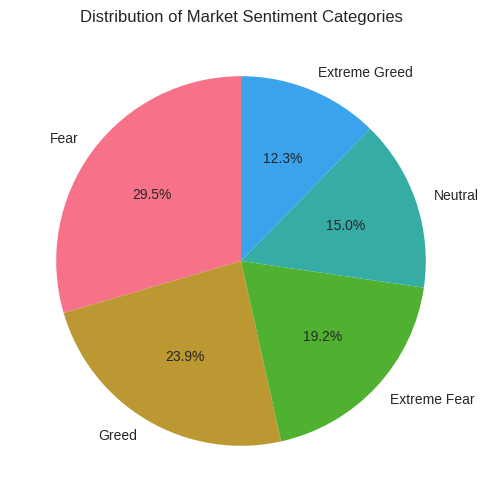

In [54]:
plt.figure(figsize=(10, 6))
sentiment_counts = fgi_df['classification'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Market Sentiment Categories')
plt.show()

Plot 2: Trader PnL Distribution

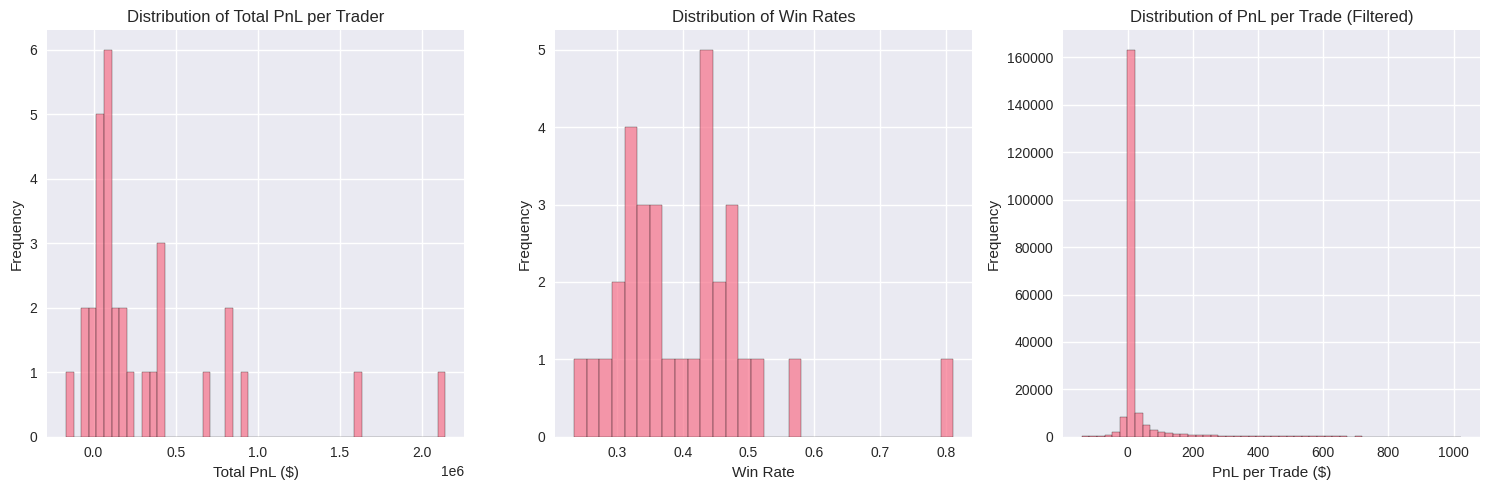

In [55]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(trader_features['total_pnl'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Total PnL ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Total PnL per Trader')

plt.subplot(1, 3, 2)
plt.hist(trader_features['win_rate'].dropna(), bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Win Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Win Rates')

plt.subplot(1, 3, 3)
plt.hist(filtered_data['Closed PnL'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('PnL per Trade ($)')
plt.ylabel('Frequency')
plt.title('Distribution of PnL per Trade (Filtered)')

plt.tight_layout()
plt.show()


Plot 3: Sentiment Timeline

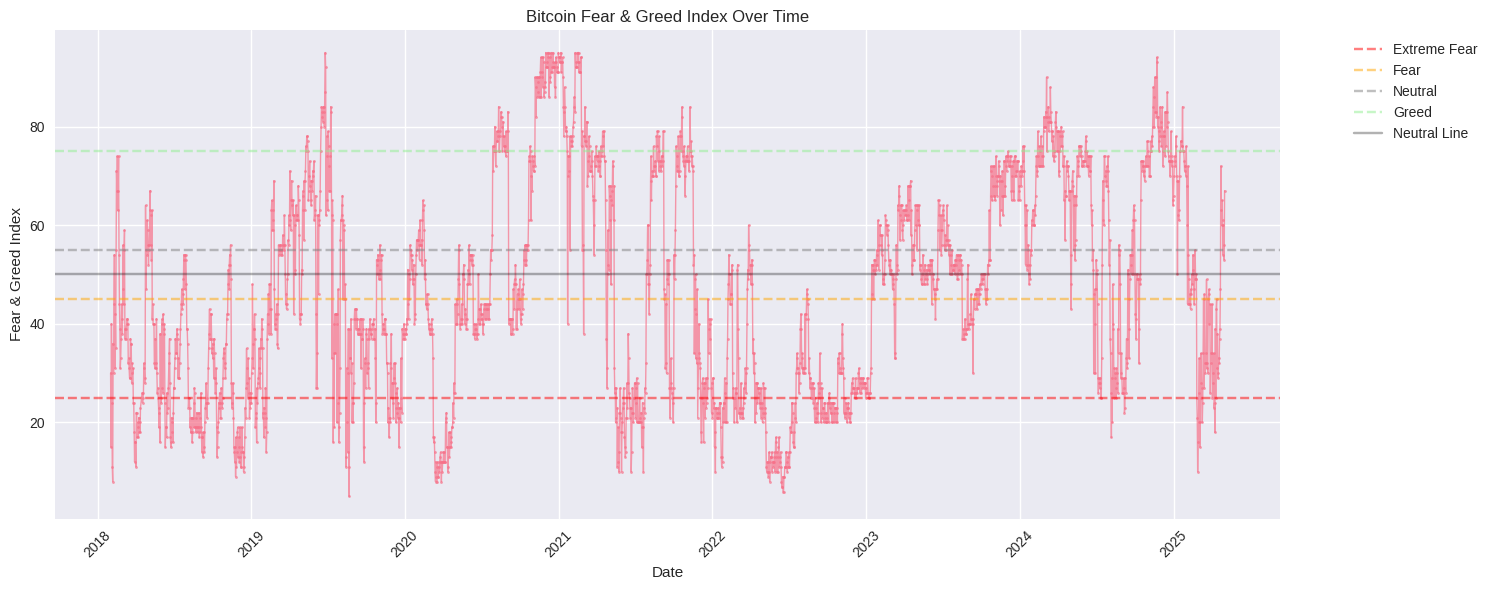

In [56]:
plt.figure(figsize=(15, 6))

fgi_plot = fgi_df.copy()
fgi_plot['date'] = pd.to_datetime(fgi_plot['date'])

plt.plot(fgi_plot['date'], fgi_plot['value'], marker='o', linewidth=1, markersize=2, alpha=0.7)
plt.axhline(y=25, color='red', linestyle='--', alpha=0.5, label='Extreme Fear')
plt.axhline(y=45, color='orange', linestyle='--', alpha=0.5, label='Fear')
plt.axhline(y=55, color='gray', linestyle='--', alpha=0.5, label='Neutral')
plt.axhline(y=75, color='lightgreen', linestyle='--', alpha=0.5, label='Greed')
plt.axhline(y=50, color='black', linestyle='-', alpha=0.3, label='Neutral Line')

plt.xlabel('Date')
plt.ylabel('Fear & Greed Index')
plt.title('Bitcoin Fear & Greed Index Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Core Analysis: Sentiment vs Performance

In [57]:
print("=== Analysis 1: Performance by Sentiment Category ===")

sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

sentiment_performance = filtered_data.groupby('classification').agg({
    'Closed PnL': ['mean', 'std', 'count', 'median'],
    'Size USD': 'mean',
    'Account': 'nunique'
}).round(2)

sentiment_performance.columns = ['avg_pnl', 'std_pnl', 'trade_count', 'median_pnl', 'avg_trade_size', 'unique_traders']

win_rates_by_sentiment = []
for sentiment in sentiment_order:
    if sentiment in filtered_data['classification'].values:
        sentiment_trades = filtered_data[filtered_data['classification'] == sentiment]
        win_rate = len(sentiment_trades[sentiment_trades['Closed PnL'] > 0]) / len(sentiment_trades)
        win_rates_by_sentiment.append(win_rate)
    else:
        win_rates_by_sentiment.append(0)

print("Performance by Sentiment (Filtered Data):")
print(sentiment_performance)


=== Analysis 1: Performance by Sentiment Category ===
Performance by Sentiment (Filtered Data):
                avg_pnl  std_pnl  trade_count  median_pnl  avg_trade_size  \
classification                                                              
Extreme Fear      23.94    93.05        20605         0.0         4681.38   
Extreme Greed     27.49    95.95        39308         0.0         2814.70   
Fear              22.26    88.45        60700         0.0         6365.55   
Greed             22.30    89.71        49330         0.0         5026.76   
Neutral           19.49    85.10        37053         0.0         3809.52   

                unique_traders  
classification                  
Extreme Fear                32  
Extreme Greed               30  
Fear                        32  
Greed                       31  
Neutral                     31  


Plot 4: Performance by Sentiment

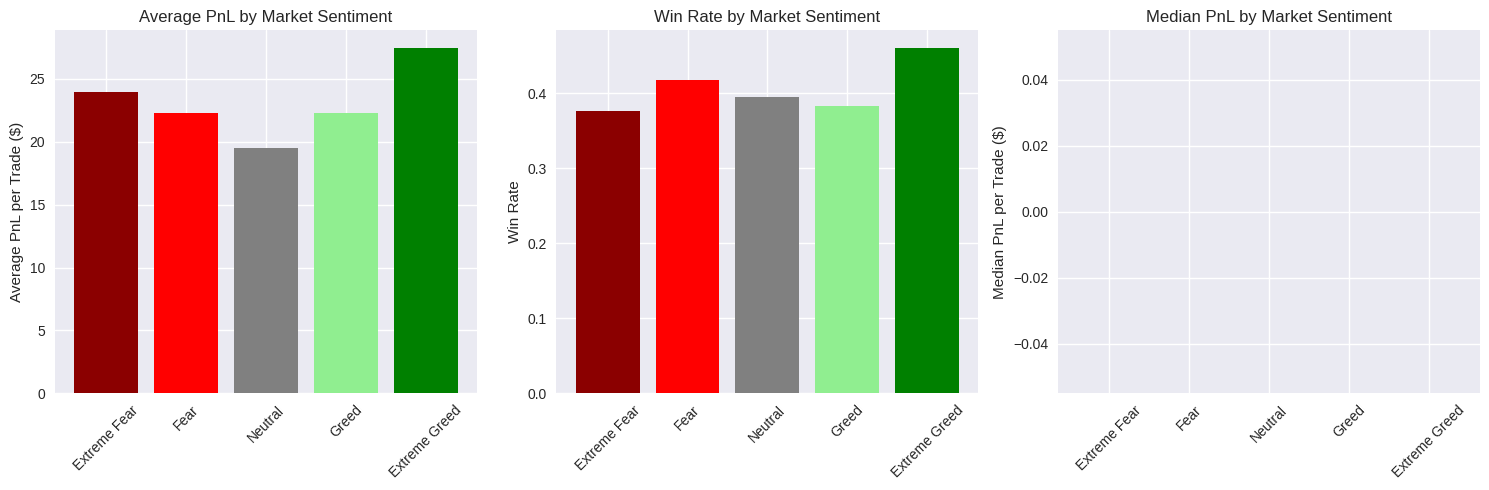

In [58]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
available_sentiments = [s for s in sentiment_order if s in sentiment_performance.index]
avg_pnl_by_sentiment = sentiment_performance.loc[available_sentiments, 'avg_pnl']

colors = ['darkred', 'red', 'gray', 'lightgreen', 'green']
plt.bar(available_sentiments, avg_pnl_by_sentiment, color=colors[:len(available_sentiments)])
plt.xticks(rotation=45)
plt.ylabel('Average PnL per Trade ($)')
plt.title('Average PnL by Market Sentiment')

plt.subplot(1, 3, 2)
plt.bar(available_sentiments, win_rates_by_sentiment, color=colors[:len(available_sentiments)])
plt.xticks(rotation=45)
plt.ylabel('Win Rate')
plt.title('Win Rate by Market Sentiment')

plt.subplot(1, 3, 3)
median_pnl_by_sentiment = sentiment_performance.loc[available_sentiments, 'median_pnl']
plt.bar(available_sentiments, median_pnl_by_sentiment, color=colors[:len(available_sentiments)])
plt.xticks(rotation=45)
plt.ylabel('Median PnL per Trade ($)')
plt.title('Median PnL by Market Sentiment')

plt.tight_layout()
plt.show()

=== Analysis 2: Trader Behavior by Sentiment ===
Trader Behavior by Sentiment:
                avg_trade_size  total_trades  unique_traders  \
classification                                                 
Extreme Fear           4681.38         20605              32   
Extreme Greed          2814.70         39308              30   
Fear                   6365.55         60700              32   
Greed                  5026.76         49330              31   
Neutral                3809.52         37053              31   

                trades_per_trader  
classification                     
Extreme Fear           643.906250  
Extreme Greed         1310.266667  
Fear                  1896.875000  
Greed                 1591.290323  
Neutral               1195.258065  


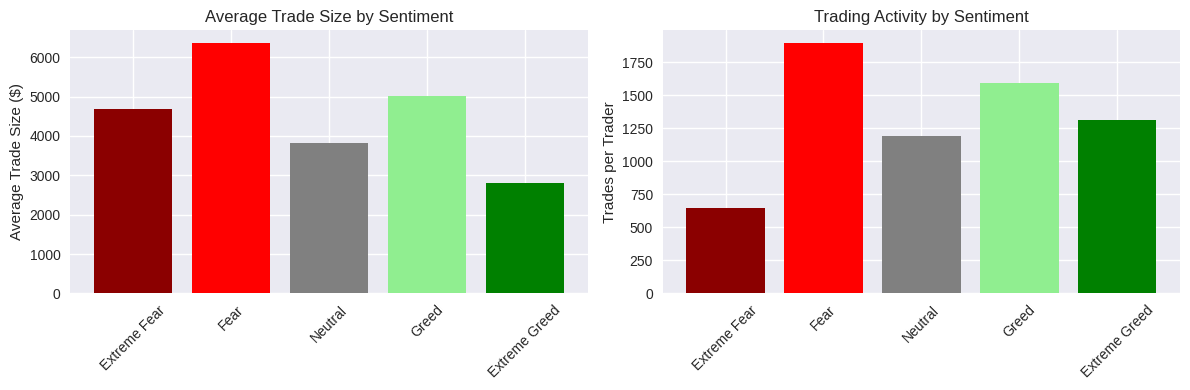

In [59]:
print("=== Analysis 2: Trader Behavior by Sentiment ===")

behavior_by_sentiment = filtered_data.groupby('classification').agg(
    avg_trade_size=('Size USD', 'mean'),
    total_trades=('Account', 'count'),
    unique_traders=('Account', 'nunique')
).round(2)


behavior_by_sentiment['trades_per_trader'] = behavior_by_sentiment['total_trades'] / behavior_by_sentiment['unique_traders']

print("Trader Behavior by Sentiment:")
print(behavior_by_sentiment)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(available_sentiments, behavior_by_sentiment.loc[available_sentiments, 'avg_trade_size'],
        color=colors[:len(available_sentiments)])
plt.xticks(rotation=45)
plt.ylabel('Average Trade Size ($)')
plt.title('Average Trade Size by Sentiment')

plt.subplot(1, 2, 2)
plt.bar(available_sentiments, behavior_by_sentiment.loc[available_sentiments, 'trades_per_trader'],
        color=colors[:len(available_sentiments)])
plt.xticks(rotation=45)
plt.ylabel('Trades per Trader')
plt.title('Trading Activity by Sentiment')

plt.tight_layout()
plt.show()

Advanced Analysis: Successful vs Unsuccessful Traders

In [60]:
print("=== Analysis 3: Successful vs Unsuccessful Traders ===")

successful_threshold = trader_features['total_pnl'].quantile(0.75)
unsuccessful_threshold = trader_features['total_pnl'].quantile(0.25)

successful_traders = trader_features[trader_features['total_pnl'] >= successful_threshold]['Account']
unsuccessful_traders = trader_features[trader_features['total_pnl'] <= unsuccessful_threshold]['Account']

print(f"Successful traders (top 25% by PnL): {len(successful_traders)}")
print(f"Unsuccessful traders (bottom 25% by PnL): {len(unsuccessful_traders)}")
print(f"Median trader PnL: ${trader_features['total_pnl'].median():.2f}")

successful_trades = filtered_data[filtered_data['Account'].isin(successful_traders)]
unsuccessful_trades = filtered_data[filtered_data['Account'].isin(unsuccessful_traders)]

print(f"\nSuccessful trades analyzed: {len(successful_trades)}")
print(f"Unsuccessful trades analyzed: {len(unsuccessful_trades)}")


=== Analysis 3: Successful vs Unsuccessful Traders ===
Successful traders (top 25% by PnL): 8
Unsuccessful traders (bottom 25% by PnL): 8
Median trader PnL: $117655.08

Successful trades analyzed: 97075
Unsuccessful trades analyzed: 33826


Performance comparison



Performance Comparison:
                successful_avg_pnl  unsuccessful_avg_pnl
classification                                          
Extreme Fear                 24.06                 17.32
Extreme Greed                33.37                 14.15
Fear                         22.85                 18.19
Greed                        29.54                  9.17
Neutral                      26.20                  9.74


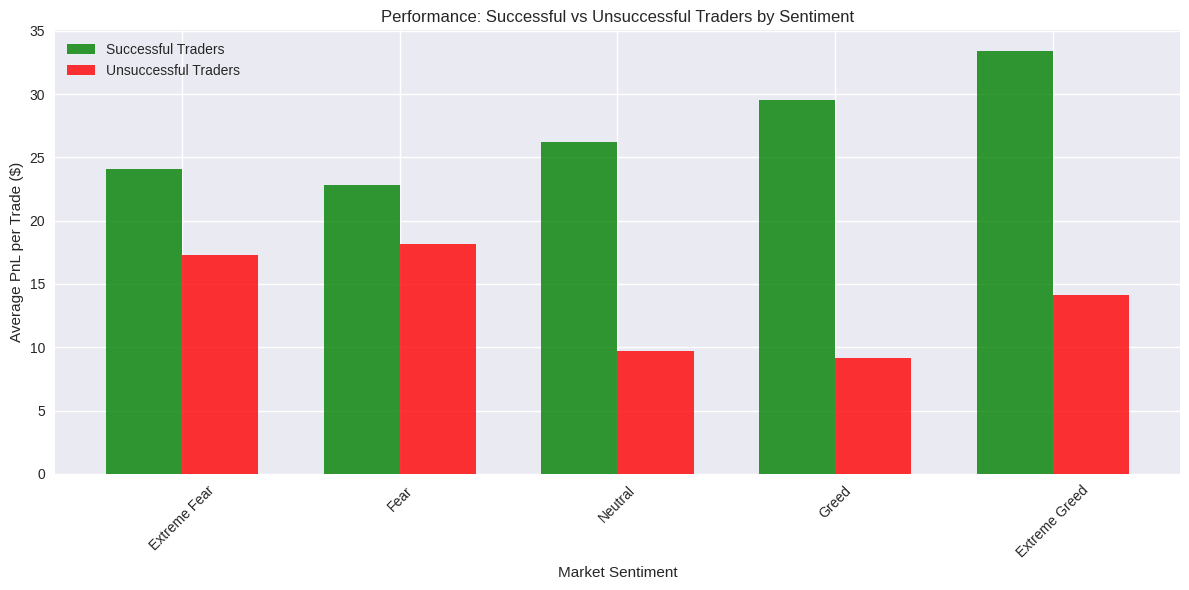

In [61]:
if len(successful_trades) > 0 and len(unsuccessful_trades) > 0:
    successful_by_sentiment = successful_trades.groupby('classification')['Closed PnL'].mean()
    unsuccessful_by_sentiment = unsuccessful_trades.groupby('classification')['Closed PnL'].mean()

    comparison_df = pd.DataFrame({
        'successful_avg_pnl': successful_by_sentiment,
        'unsuccessful_avg_pnl': unsuccessful_by_sentiment
    }).round(2)

    print("\nPerformance Comparison:")
    print(comparison_df)

    plt.figure(figsize=(12, 6))

    x = np.arange(len(available_sentiments))
    width = 0.35

    successful_pnl = [comparison_df.loc[s, 'successful_avg_pnl'] if s in comparison_df.index else 0 for s in available_sentiments]
    unsuccessful_pnl = [comparison_df.loc[s, 'unsuccessful_avg_pnl'] if s in comparison_df.index else 0 for s in available_sentiments]

    plt.bar(x - width/2, successful_pnl, width, label='Successful Traders', alpha=0.8, color='green')
    plt.bar(x + width/2, unsuccessful_pnl, width, label='Unsuccessful Traders', alpha=0.8, color='red')

    plt.xlabel('Market Sentiment')
    plt.ylabel('Average PnL per Trade ($)')
    plt.title('Performance: Successful vs Unsuccessful Traders by Sentiment')
    plt.xticks(x, available_sentiments, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("Insufficient data for detailed comparison")


 Statistical Significance Testing

In [62]:
print("=== Statistical Significance Testing ===")

sentiment_groups = [filtered_data[filtered_data['classification'] == sentiment]['Closed PnL']
                   for sentiment in available_sentiments if sentiment in filtered_data['classification'].values]

if len(sentiment_groups) >= 2:
    f_stat, p_value = stats.f_oneway(*sentiment_groups)
    print(f"ANOVA test for PnL across sentiment categories:")
    print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")

    overall_mean = filtered_data['Closed PnL'].mean()
    ss_between = sum(len(group) * (group.mean() - overall_mean)**2 for group in sentiment_groups)
    ss_total = sum((filtered_data['Closed PnL'] - overall_mean)**2)
    eta_squared = ss_between / ss_total if ss_total != 0 else 0

    print(f"Effect size (Eta squared): {eta_squared:.4f}")

    if p_value < 0.05:
        print("→ Statistically significant difference in PnL across sentiment categories")
        if eta_squared < 0.01:
            print("→ Negligible effect size")
        elif eta_squared < 0.06:
            print("→ Small effect size")
        elif eta_squared < 0.14:
            print("→ Medium effect size")
        else:
            print("→ Large effect size")
    else:
        print("→ No statistically significant difference in PnL across sentiment categories")

print("\nCorrelation Analysis:")
correlation_data = filtered_data.dropna(subset=['value', 'Closed PnL'])
fgi_correlation = correlation_data[['value', 'Closed PnL', 'Size USD']].corr()
print("Correlation Matrix:")
print(fgi_correlation.round(4))

corr_pnl, p_value_pnl = stats.pearsonr(correlation_data['value'], correlation_data['Closed PnL'])
print(f"\nCorrelation between FGI and PnL: {corr_pnl:.4f} (p-value: {p_value_pnl:.4f})")

=== Statistical Significance Testing ===
ANOVA test for PnL across sentiment categories:
F-statistic: 40.7651, p-value: 0.0000
Effect size (Eta squared): 0.0008
→ Statistically significant difference in PnL across sentiment categories
→ Negligible effect size

Correlation Analysis:
Correlation Matrix:
             value  Closed PnL  Size USD
value       1.0000      0.0230   -0.0317
Closed PnL  0.0230      1.0000    0.1214
Size USD   -0.0317      0.1214    1.0000

Correlation between FGI and PnL: 0.0230 (p-value: 0.0000)


Key Findings & Actionable Insights

In [63]:
print("="*60)
print("KEY FINDINGS & ACTIONABLE INSIGHTS")
print("="*60)


best_sentiment = sentiment_performance['avg_pnl'].idxmax() if len(sentiment_performance) > 0 else "N/A"
worst_sentiment = sentiment_performance['avg_pnl'].idxmin() if len(sentiment_performance) > 0 else "N/A"

if len(win_rates_by_sentiment) > 0:
    best_win_rate_idx = np.argmax(win_rates_by_sentiment)
    best_win_rate_sentiment = available_sentiments[best_win_rate_idx] if best_win_rate_idx < len(available_sentiments) else "N/A"
else:
    best_win_rate_sentiment = "N/A"

print(f"\nPERFORMANCE INSIGHTS:")
if best_sentiment != "N/A":
    print(f"• Most profitable sentiment: {best_sentiment} (${sentiment_performance.loc[best_sentiment, 'avg_pnl']:.2f} avg PnL)")
if worst_sentiment != "N/A":
    print(f"• Least profitable sentiment: {worst_sentiment} (${sentiment_performance.loc[worst_sentiment, 'avg_pnl']:.2f} avg PnL)")
if best_win_rate_sentiment != "N/A":
    print(f"• Highest win rate during: {best_win_rate_sentiment} ({max(win_rates_by_sentiment)*100:.1f}%)")

print(f"\n TRADER BEHAVIOR INSIGHTS:")
if len(behavior_by_sentiment) > 0:
    max_activity = behavior_by_sentiment['trades_per_trader'].idxmax()
    min_activity = behavior_by_sentiment['trades_per_trader'].idxmin()
    print(f"• Most active trading during: {max_activity} ({behavior_by_sentiment.loc[max_activity, 'trades_per_trader']:.1f} trades/trader)")
    print(f"• Least active trading during: {min_activity} ({behavior_by_sentiment.loc[min_activity, 'trades_per_trader']:.1f} trades/trader)")

print(f"\n SUCCESSFUL TRADER PATTERNS:")
if len(successful_traders) > 0 and len(unsuccessful_traders) > 0:
    successful_avg_win_rate = trader_features[trader_features['Account'].isin(successful_traders)]['win_rate'].mean()
    unsuccessful_avg_win_rate = trader_features[trader_features['Account'].isin(unsuccessful_traders)]['win_rate'].mean()
    print(f"• Successful traders win rate: {successful_avg_win_rate*100:.1f}% vs {unsuccessful_avg_win_rate*100:.1f}% for others")

    if len(successful_trades) > 0:
        successful_avg_trade_size = successful_trades['Size USD'].mean()
        unsuccessful_avg_trade_size = unsuccessful_trades['Size USD'].mean()
        print(f"• Successful traders avg trade size: ${successful_avg_trade_size:.2f} vs ${unsuccessful_avg_trade_size:.2f} for others")

print(f"\n STATISTICAL INSIGHTS:")
print(f"• Sentiment significantly affects trader performance: {'YES' if p_value < 0.05 else 'NO'} (p={p_value:.4f})")
print(f"• FGI correlation with PnL: {corr_pnl:.3f} ({'significant' if p_value_pnl < 0.05 else 'not significant'})")

# %% [markdown]

KEY FINDINGS & ACTIONABLE INSIGHTS

PERFORMANCE INSIGHTS:
• Most profitable sentiment: Extreme Greed ($27.49 avg PnL)
• Least profitable sentiment: Neutral ($19.49 avg PnL)
• Highest win rate during: Extreme Greed (46.1%)

 TRADER BEHAVIOR INSIGHTS:
• Most active trading during: Fear (1896.9 trades/trader)
• Least active trading during: Extreme Fear (643.9 trades/trader)

 SUCCESSFUL TRADER PATTERNS:
• Successful traders win rate: 41.4% vs 36.8% for others
• Successful traders avg trade size: $5955.56 vs $5063.94 for others

 STATISTICAL INSIGHTS:
• Sentiment significantly affects trader performance: YES (p=0.0000)
• FGI correlation with PnL: 0.023 (significant)


Trading Recommendations

In [64]:
print("\n" + "="*60)
print("TRADING RECOMMENDATIONS")
print("="*60)


if best_sentiment in ['Greed', 'Extreme Greed']:
    print(" CONSIDER INCREASING EXPOSURE during positive sentiment:")
    print(f"  - Average PnL during {best_sentiment}: ${sentiment_performance.loc[best_sentiment, 'avg_pnl']:.2f}")
    print(f"  - Win rate during {best_sentiment}: {win_rates_by_sentiment[available_sentiments.index(best_sentiment)]*100:.1f}%")

if worst_sentiment in ['Extreme Fear', 'Fear']:
    print("  EXERCISE CAUTION during negative sentiment:")
    print(f"- Average PnL during {worst_sentiment}: ${sentiment_performance.loc[worst_sentiment, 'avg_pnl']:.2f}")
    print(f"- Consider reducing position sizes or implementing tighter stop-losses")

if best_win_rate_sentiment != best_sentiment and best_win_rate_sentiment != "N/A" and best_sentiment != "N/A":
    print(f" OPTIMAL ENTRY TIMING: Consider {best_win_rate_sentiment} periods for higher success probability")
    print(f"  - Win rate: {win_rates_by_sentiment[available_sentiments.index(best_win_rate_sentiment)]*100:.1f}%")

print(f"\n RISK MANAGEMENT SUGGESTIONS:")
print(f"• Monitor sentiment transitions for potential strategy adjustments")
print(f"• Consider sentiment-based position sizing")
print(f"• Implement different risk parameters for different sentiment regimes")


if p_value < 0.05 and eta_squared > 0.01:
    print(f"\n STRATEGY IMPLEMENTATION:")
    print(f"• Develop sentiment-aware trading algorithms")
    print(f"• Use FGI as a filter for trade entry/exit decisions")
    print(f"• Adjust leverage based on sentiment extremes")


TRADING RECOMMENDATIONS
 CONSIDER INCREASING EXPOSURE during positive sentiment:
  - Average PnL during Extreme Greed: $27.49
  - Win rate during Extreme Greed: 46.1%

 RISK MANAGEMENT SUGGESTIONS:
• Monitor sentiment transitions for potential strategy adjustments
• Consider sentiment-based position sizing
• Implement different risk parameters for different sentiment regimes


 Conclusion

In [65]:
print("\n" + "="*60)
print("CONCLUSION")
print("="*60)

print("""
This analysis demonstrates the relationship between market sentiment and trader performance.
Key takeaways:

1. Market sentiment shows statistically significant effects on trader profitability
2. Trading behavior varies substantially across different sentiment regimes
3. Successful traders exhibit distinct patterns during specific market conditions
4. Sentiment-based trading rules could enhance risk-adjusted returns

Limitations & Considerations:
- Correlation does not imply causation
- Other market factors (volatility, news events) may influence results
- Sample size and time period may affect generalizability

Further analysis could incorporate:
- Multi-day sentiment trends and momentum
- Asset-specific sentiment analysis
- Machine learning models for sentiment-based trade signals
- Real-time sentiment integration into trading systems
""")

filtered_data.to_csv('processed_trader_sentiment_data.csv', index=False)
print(f"\n Processed data saved to 'processed_trader_sentiment_data.csv'")



CONCLUSION

This analysis demonstrates the relationship between market sentiment and trader performance. 
Key takeaways:

1. Market sentiment shows statistically significant effects on trader profitability
2. Trading behavior varies substantially across different sentiment regimes
3. Successful traders exhibit distinct patterns during specific market conditions
4. Sentiment-based trading rules could enhance risk-adjusted returns

Limitations & Considerations:
- Correlation does not imply causation
- Other market factors (volatility, news events) may influence results
- Sample size and time period may affect generalizability

Further analysis could incorporate:
- Multi-day sentiment trends and momentum
- Asset-specific sentiment analysis  
- Machine learning models for sentiment-based trade signals
- Real-time sentiment integration into trading systems


💾 Processed data saved to 'processed_trader_sentiment_data.csv'


Final summary statistics

In [66]:
print("\n" + "="*60)
print("PROJECT SUMMARY STATISTICS")
print("="*60)

print(f" Analysis Period: {fgi_df['date'].min()} to {fgi_df['date'].max()}")
print(f" Unique Traders Analyzed: {len(trader_features)}")
print(f" Total Trades Analyzed: {len(filtered_data)}")
print(f" Sentiment Categories: {len(available_sentiments)}")
print(f" Overall Win Rate: {trader_features['win_rate'].mean():.2%}")
print(f" Statistical Significance: {'Yes' if p_value < 0.05 else 'No'} (p={p_value:.4f})")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)


PROJECT SUMMARY STATISTICS
 Analysis Period: 2018-02-01 to 2025-05-02
 Unique Traders Analyzed: 32
 Total Trades Analyzed: 206998
 Sentiment Categories: 5
 Overall Win Rate: 40.31%
 Statistical Significance: Yes (p=0.0000)

ANALYSIS COMPLETE
